In [1]:
import sys
import os
from os.path import join, exists, abspath
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, pearsonr
from scipy.spatial.distance import squareform
import h5py
import seaborn as sns

from tqdm import tqdm

In [2]:
import warnings

In [3]:
import nibabel as nb
from nilearn import plotting
from nipype.interfaces import fsl

In [4]:
dir_current = os.getcwd().replace('\\','/')
dir_current

'D:/mobaxterm/sungbeenpark/github/diedrichsenlab/scripts'

In [5]:
tmp = dir_current.split('/')
idx = [idx for idx, ss in enumerate(tmp) if ss=='github' ][0]
dir_git = '/'.join(tmp[:idx+1])
exists(dir_git)

True

In [6]:
path_module = abspath(join(dir_git,'nitools'))
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import nitools as nt

added the path, D:\mobaxterm\sungbeenpark\github\nitools


In [7]:
path_module = abspath(join(dir_git,'SUITPy'))
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import SUITPy as suit

added the path, D:\mobaxterm\sungbeenpark\github\SUITPy


In [8]:
path_module = abspath(dir_git)
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import surfAnalysisPy as surf

added the path, D:\mobaxterm\sungbeenpark\github


In [9]:
path_module = abspath(join(dir_git,'PcmPy'))
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import PcmPy as pcm

added the path, D:\mobaxterm\sungbeenpark\github\PcmPy


---

In [10]:
dir_work = 'D:/mobaxterm/sungbeenpark/github/diedrichsenlab/atlas'
dir_atlas = join(dir_work,'fs_LR_32k')
dir_atlas

'D:/mobaxterm/sungbeenpark/github/diedrichsenlab/atlas\\fs_LR_32k'

---

### ROIs

In [11]:
underlay = join(dir_atlas,'fs_LR.32k.LR.sulc.dscalar.gii')
border = join(dir_git,'surfAnalysisPy/standard_mesh/fs_L/fs_LR.32k.L.border')

In [12]:
fname = join(dir_atlas,'ROI.L.SSS.label.gii')
list_roi = ['SMA', 'PMv', 'PMd', 'M1', 'S1', 'SPLa', 'SPLp', 'DSVC', 'MT+', 'VSVC', 'EAC']

In [13]:
img = nb.load(fname)
cols = nt.get_gifti_column_names(img)
print('column heads (%d):\n'%len(cols),cols)

data = img.darrays[0].data
print(np.unique(data), data.shape)

column heads (1):
 ['col_1']
[ 0  1  2  3  4  5  6  7  8  9 10 11] (32492,)


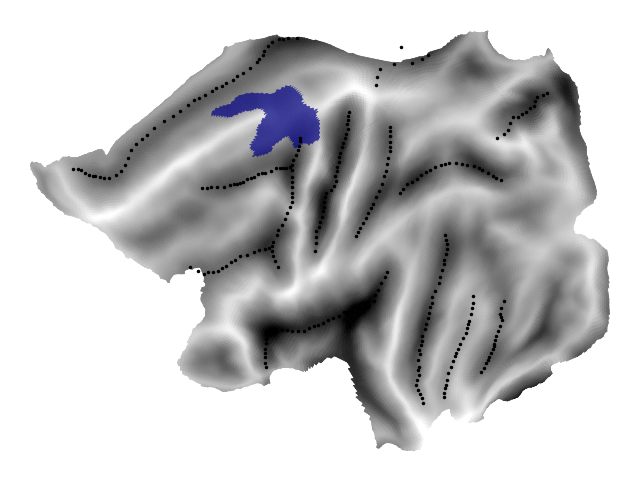

In [14]:
fig = plt.figure(figsize=(8,6))
ax = surf.plot.plotmap(
    data=data*(data==1),
    surf='fs32k_L',
    underlay=underlay, alpha=0.7, cmap=cm.jet,
    borders=border, bordercolor='black', bordersize=3,
    overlay_type='func', label_names=list_roi, render='matplotlib'
)

In [15]:
## SMA
for ii, roi in enumerate(list_roi):
    val = ii+1
    ## +1 on each index for matlab
    vertices = np.where(data*(data==val)>0)[0]+1
    np.savetxt(join(dir_atlas,'%s.vertice.txt'%roi), vertices, fmt='%d', delimiter=' ')
    print(roi, len(vertices))

SMA 683
PMv 302
PMd 633
M1 305
S1 773
SPLa 711
SPLp 375
DSVC 462
MT+ 743
VSVC 596
EAC 615


---

## GifTi

In [16]:
dir_surf = 'F:/SeqSpatialSupp_fMRI/surfaceWB'
exists(dir_surf)

True

In [17]:
subj = 'S01'

fname = join(dir_surf,subj,'%s.L.white.32k.surf.gii'%subj)
img_white = nb.load(fname)
cols = nt.get_gifti_column_names(img_white)
print('column heads (%d):\n'%len(cols),cols)
for darray in img_white.darrays:
    print(darray.data.shape)

fname = join(dir_surf,subj,'%s.L.pial.32k.surf.gii'%subj)
img_pial = nb.load(fname)
cols = nt.get_gifti_column_names(img_pial)
print('column heads (%d):\n'%len(cols),cols)
for darray in img_pial.darrays:
    print(darray.data.shape)

column heads (2):
 ['#1', '#2']
(32492, 3)
(64980, 3)
column heads (2):
 ['#1', '#2']
(32492, 3)
(64980, 3)


In [18]:
c1 = img_white.darrays[0].data
faces = img_white.darrays[1].data
numVerts = c1.shape[0]

c2 = img_pial.darrays[0].data

In [19]:
depths = [0,0.2,0.4,0.6,0.8,1.0]
numPoints = len(depths)

In [20]:
# Get the indices for all the points being sampled
indices = np.zeros((numPoints,numVerts,3),dtype=int)
indices.shape

(6, 32492, 3)

---

## Mapping (volume to surface)

In [21]:
dir_data = 'F:/SeqSpatialSupp_fMRI/imaging_data'
exists(dir_data)

True

In [22]:
list_fname = glob(join(dir_data,subj,'u%s_run_??.nii'%subj))
len(list_fname)

8

In [23]:
fname = list_fname[0]
img = nb.load(fname)
print(img.shape)
numTimes = img.shape[-1]

(116, 116, 57, 410)


In [24]:
for i in range(numPoints):
    c = (1-depths[i])*c1.T+depths[i]*c2.T
    ijk = nt.coords_to_voxelidxs(c,img)
    indices[i] = ijk.T

### Read the data and map it

In [25]:
data = img.get_fdata()
data_mapped = np.zeros((numPoints,numVerts,numTimes))
for t in range(numTimes):
    X = data[:,:,:,t]
    for p in range(numPoints):
        data_mapped[p,:,t] = X[indices[p,:,0],indices[p,:,1],indices[p,:,2]]
        outside = (indices[p,:,:]<0).any(axis=1) # These are vertices outside the volume
        data_mapped[p,:,t][outside] = np.nan

# Determine the right statistics
data_mapped = np.nanmean(data_mapped,axis=0)
data_mapped.shape

D:\mobaxterm\slash\tmp\ipykernel_14952\191879379.py:11: RuntimeWarning: Mean of empty slice
  data_mapped = np.nanmean(data_mapped,axis=0)


(32492, 410)

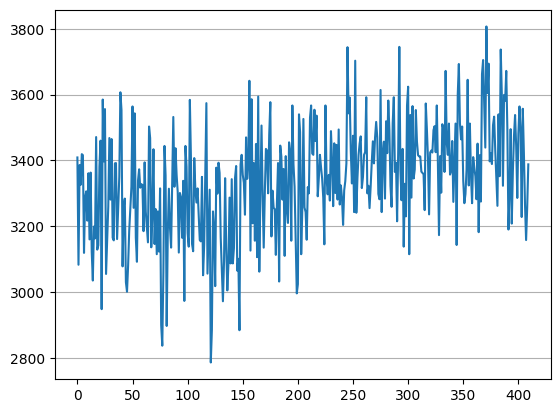

In [26]:
plt.plot(range(numTimes),data_mapped[200,:])
plt.grid(axis='y')

<Axes: >

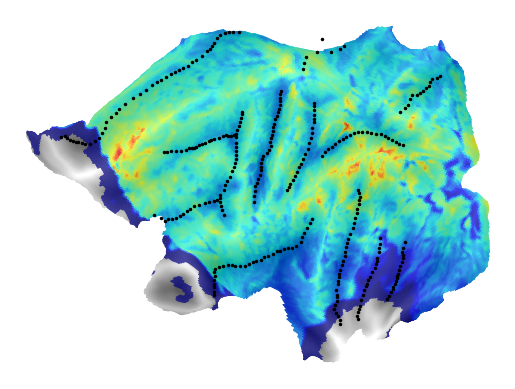

In [27]:
surf.plot.plotmap(
    data=data_mapped[:,100],
    surf='fs32k_L',
    underlay=underlay, alpha=0.7, cmap=cm.jet,
    borders=border, bordercolor='black', bordersize=3,
    overlay_type='func', render='matplotlib'
)

## Mapped timeserise $Y_{raw}$ : (nVoxels, nTimes)

- xX.xKXs = $K*W*X$ : filtered and whitened design matrix
- $y_{filt}$ = $K*W*y$ : filtered and whitened data
- xX.pKX = spm_pinv$(xX.xKXs)$ : pseudo-inverse of filtered and whitened design matrix
- $\beta$ = $xX.pKX*y_{filt}$ : parameter estimates

In [28]:
dir_glm = 'F:/SeqSpatialSupp_fMRI/glm_3'
exists(dir_glm)

True

In [29]:
fname = join(dir_glm,subj,'SPM.mat')
exists(fname)

True

In [76]:
# feature = h5py.File(fname, 'r')
# # feature = scipy.io.loadmat(fname)
# print(feature.keys())

# data = feature['SPM']
# data.keys()

<KeysViewHDF5 ['#refs#', 'SPM']>


<KeysViewHDF5 ['ResStats', 'SPMid', 'Sess', 'VM', 'VResMS', 'Vbeta', 'factor', 'nscan', 'swd', 'xBF', 'xCon', 'xGX', 'xM', 'xVi', 'xVol', 'xX', 'xY', 'xsDes']>

In [92]:
# K = data['xX']['K']['X0']
# K

<HDF5 dataset "X0": shape (8, 1), type "|O">

---

In [30]:
subj = 'S01'

# White -gray matter surface 
fname = join(dir_surf,subj,'%s.L.white.32k.surf.gii'%subj)
img_white = nb.load(fname)
cols = nt.get_gifti_column_names(img_white)
print('column heads (%d):\n'%len(cols),cols)
for darray in img_white.darrays:
    print(darray.data.shape)

# Pial surface
fname = join(dir_surf,subj,'%s.L.pial.32k.surf.gii'%subj)
img_pial = nb.load(fname)
cols = nt.get_gifti_column_names(img_pial)
print('column heads (%d):\n'%len(cols),cols)
for darray in img_pial.darrays:
    print(darray.data.shape)

# Sulcal depth 
fname = join(dir_surf,subj,'%s.L.sulc.32k.shape.gii'%subj)
img_sulc = nb.load(fname)
cols = nt.get_gifti_column_names(img_sulc)
print('column heads (%d):\n'%len(cols),cols)
for darray in img_pial.darrays:
    print(darray.data.shape)

column heads (2):
 ['#1', '#2']
(32492, 3)
(64980, 3)
column heads (2):
 ['#1', '#2']
(32492, 3)
(64980, 3)
column heads (1):
 ['lh.sulc']
(32492, 3)
(64980, 3)


In [31]:
dir_glm = 'F:/SeqSpatialSupp_fMRI/glm_3'
exists(dir_glm)

True

In [35]:
ResMS = join(dir_glm,subj,'ResMS.nii')
img_ResMS = nb.load(ResMS)
img_ResMS.shape

(116, 116, 57)

In [36]:
Data = surf.map.vol_to_surf(
    volumes=[ResMS],
    whiteSurfGifti=join(dir_surf,subj,'%s.L.white.32k.surf.gii'%subj),
    pialSurfGifti=join(dir_surf,subj,'%s.L.pial.32k.surf.gii'%subj),
    excludeThres=0.9,
    stats='nanmean'
)

<Axes: >

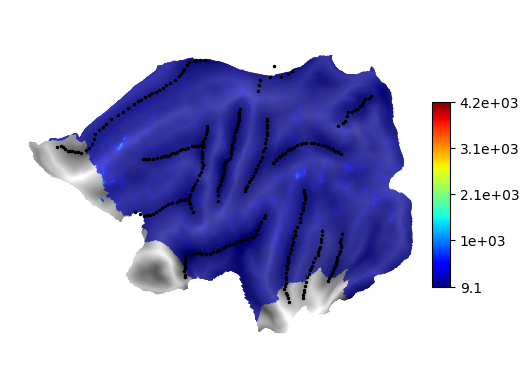

In [38]:
surf.plot.plotmap(
    data=Data,
    surf='fs32k_L',
    underlay=underlay, alpha=0.7, cmap=cm.jet, colorbar=True,
    borders=border, bordercolor='black', bordersize=3,
    overlay_type='func', render='matplotlib'
)